## listing_nbhd.zip 
> https://drive.google.com/file/d/1RXzoFit_B0UQJcg_xo29pm1619wTgTE2/view?usp=sharing

>contains counts of venues around the r-km neighbourhood around each listing, r=0.125,0.25,0.5,1,2,4

## venues_count.csv 
>https://drive.google.com/file/d/1VcgnE5O0lRUJ8SqZBfIKH5bR9Z_YGXJw/view?usp=sharing

>count the total number of each type of venues in a sorted order

In [1]:
# download to the current directory

!gdown --id 1RXzoFit_B0UQJcg_xo29pm1619wTgTE2 -O listings_nbhd.zip
!unzip *.zip

!gdown --id 1VcgnE5O0lRUJ8SqZBfIKH5bR9Z_YGXJw -O venues_count.csv

Downloading...
From: https://drive.google.com/uc?id=1RXzoFit_B0UQJcg_xo29pm1619wTgTE2
To: /content/listings_nbhd.zip
25.0MB [00:00, 117MB/s]
Archive:  listings_nbhd.zip
  inflating: listings_0.125-km_nbhd.csv  
  inflating: listings_0.25-km_nbhd.csv  
  inflating: listings_0.5-km_nbhd.csv  
  inflating: listings_1-km_nbhd.csv  
  inflating: listings_2-km_nbhd.csv  
  inflating: listings_4-km_nbhd.csv  
Downloading...
From: https://drive.google.com/uc?id=1VcgnE5O0lRUJ8SqZBfIKH5bR9Z_YGXJw
To: /content/venues_count.csv
100% 1.53k/1.53k [00:00<00:00, 5.85MB/s]


In [2]:
## original dataset, not needed 
!gdown --id 1ecgxSTxCmhCvVTSFgUBRGVjyGf3rLREW -O dataset.zip
!unzip dataset.zip
!gzip -dk Datasets/*.gz

Downloading...
From: https://drive.google.com/uc?id=1ecgxSTxCmhCvVTSFgUBRGVjyGf3rLREW
To: /content/dataset.zip
69.1MB [00:01, 61.8MB/s]
Archive:  dataset.zip
  inflating: Datasets/econ_state.csv  
  inflating: Datasets/demographics.csv  
  inflating: Datasets/venues.csv.gz  
  inflating: Datasets/real_estate.csv.gz  
  inflating: Datasets/listings.csv   
  inflating: Datasets/calendar.csv.gz  


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def getNonSingleton(df):
  return df[df['num_venues']>=1]

In [59]:
r=[0.125,0.25,0.5,1,2,4]
dfs={}
for i in r:
  dfs[i]=pd.read_csv(f'listings_{i}-km_nbhd.csv')

index=dfs[4]['num_venues']>=1
for i in r:
  dfs[i]=dfs[i][index]
  # getNonSingleton(dfs[i]).to_csv(f'listings_{i}-km_nbhd_filtered.csv')
# create_report(df).save('listing_nbhd')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## look at the struture of dfs

In [60]:
dfs.keys() # distance to listings

dict_keys([0.125, 0.25, 0.5, 1, 2, 4])

Add columns for number of multiple listings under the host's id and part of multiple listings column

In [61]:
listings_df = pd.read_csv('Datasets/listings.csv')

#Add a column detailing how many listings under host_id
#create a dictionary of ids
id_grouping = listings_df.groupby('host_id').count().sort_values('accommodates', ascending = False).iloc[:,:1]
id_grouping.reset_index(level = 0, inplace =True)
id_dict = dict(zip(id_grouping.host_id,id_grouping.accommodates))

#map dictionary to new dataframe column
listings_df['No_properties_under_id'] = listings_df['host_id'].map(id_dict)

In [62]:
#Adding listings_under_host_id column to each of the km venue dfs that notes how many properties the host owns

# create a dictionary of ids

listing_id_dict = dict(zip(listings_df.id,listings_df.No_properties_under_id))

for i in r:
  dfs[i]['listings_under_host_id'] = dfs[i]['listing_id'].map(listing_id_dict)

In [123]:
#add multiple_listing column
for i in r:
  dfs[i].loc[dfs[i]['listings_under_host_id']==1, 'multiple_listing'] = 'F'
  dfs[i].loc[dfs[i]['listings_under_host_id']>1, 'multiple_listing'] = 'T'

In [133]:
#add multiple_listing columns for 2-5_listings, 6-10_listings, 11+_listings
for i in r:
  dfs[i]['num_listings']='1'
  dfs[i].loc[dfs[i]['listings_under_host_id']>1, 'num_listings'] = '2-5'
  dfs[i].loc[dfs[i]['listings_under_host_id']>5, 'num_listings'] = '6-10'
  dfs[i].loc[dfs[i]['listings_under_host_id']>10, 'num_listings'] = '10+'

## look at the structure of venue

In [16]:
venue_df=pd.read_csv('venues_count.csv',index_col=0)
venue_df.iloc[:15,:]

,Count
point_of_interest,121007
establishment,121007
store,55114
food,31473
transit_station,24487
restaurant,21817
bus_station,19618
home_goods_store,8066
health,6946
clothing_store,6364


## plotting the density

In [65]:
venuesCol=[*venue_df.index]+['num_venues']
len(venuesCol)

101

In [66]:
venueTypes=[*venue_df.index]
venueTypes[:6]

['point_of_interest',
 'establishment',
 'store',
 'food',
 'transit_station',
 'restaurant']

In [67]:
venuesToPlot=(venueTypes[:6]+['num_venues'])

In [68]:
venuesToPlot

['point_of_interest',
 'establishment',
 'store',
 'food',
 'transit_station',
 'restaurant',
 'num_venues']

In [134]:
dfs_clean={i:dfs[i].copy() for i in r}
area={}
pi=3.1415926
area[r[0]]=pi*r[0]*r[0]
for j in range(1,len(r)):
  dfs_clean[r[j]][venuesCol]=dfs[r[j]][venuesCol]-dfs[r[j-1]][venuesCol]
  area[r[j]]=pi*r[j]*r[j]-pi*r[j-1]*r[j-1]


In [135]:
dfs_density={i:dfs[i].copy() for i in r}

for i in r:
  dfs_density[i][venuesCol]=dfs[i][venuesCol]*(1/area[i])



In [136]:

dfs_density[i][['listing_id',venues_type,'multiple_listing','num_listings']]

,listing_id,point_of_interest,multiple_listing,num_listings
0,109,65.120899,F,1
1,344,47.719958,F,1
2,941,169.871379,F,1
3,2404,86.182403,F,1
4,2732,92.283343,T,2-5
...,...,...,...,...
50254,19034190,131.408934,T,2-5
50255,19035492,121.249543,T,2-5
50256,19035679,17.692725,F,1
50257,19037230,63.847659,F,1


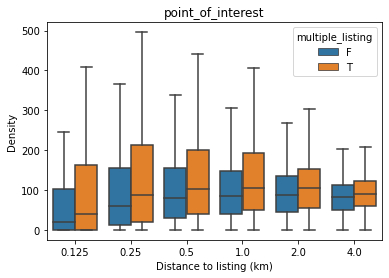

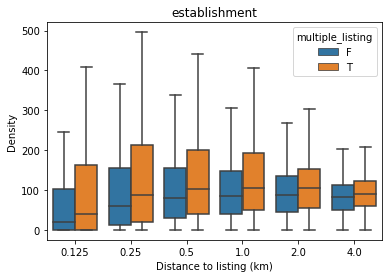

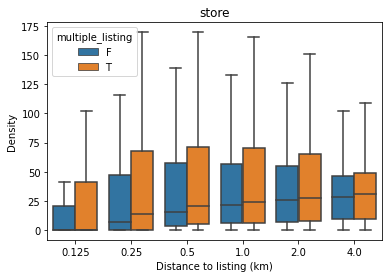

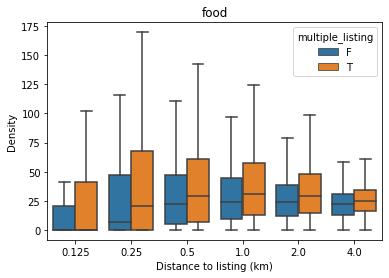

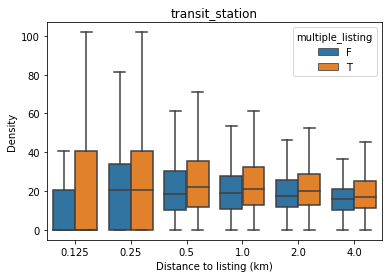

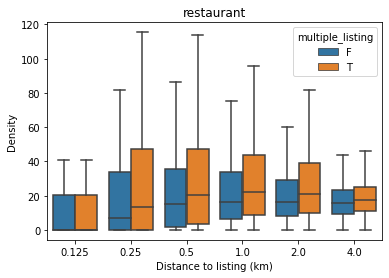

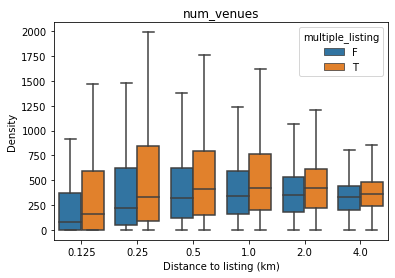

In [141]:
venuesToPlot=(venueTypes[:6]+['num_venues'])
for venues_type in venuesToPlot:
  agg_df=pd.concat({i:dfs_density[i][['listing_id',venues_type,'multiple_listing','num_listings']].set_index('listing_id') for i in r}).reset_index().rename(columns={'level_0':'r'})
  sns.boxplot(data=agg_df,x='r',y=venues_type,hue='multiple_listing', showfliers = False)

  plt.title(venues_type)
  plt.xlabel('Distance to listing (km)')
  plt.ylabel('Density')
  
  plt.savefig(f'{venues_type}.png')
  plt.show()

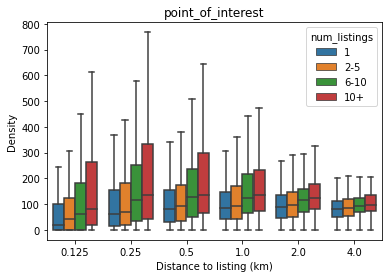

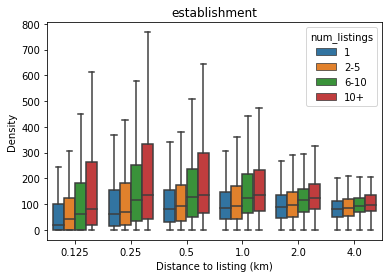

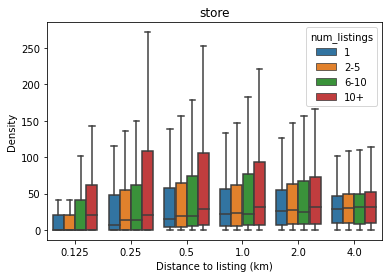

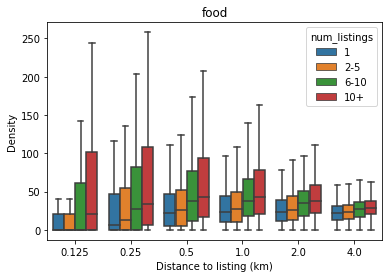

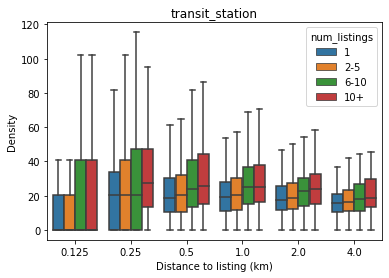

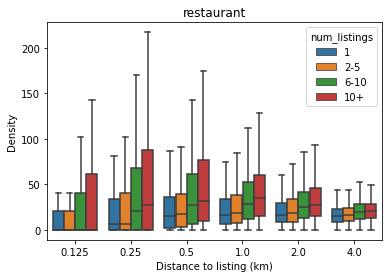

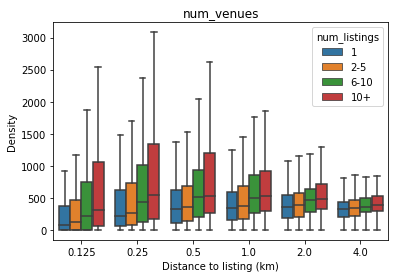

In [140]:
venuesToPlot=(venueTypes[:6]+['num_venues'])
for venues_type in venuesToPlot:
  agg_df=pd.concat({i:dfs_density[i][['listing_id',venues_type,'multiple_listing','num_listings']].set_index('listing_id') for i in r}).reset_index().rename(columns={'level_0':'r'})
  sns.boxplot(data=agg_df,x='r',y=venues_type,hue='num_listings', showfliers = False)

  plt.title(venues_type)
  plt.xlabel('Distance to listing (km)')
  plt.ylabel('Density')
  
  plt.savefig(f'{venues_type}_4cat.png')
  plt.show()

In [142]:
!zip figures.zip *.png

updating: establishment.png (deflated 9%)
updating: food.png (deflated 8%)
updating: num_venues.png (deflated 9%)
updating: point_of_interest.png (deflated 10%)
updating: restaurant.png (deflated 8%)
updating: store.png (deflated 9%)
updating: transit_station.png (deflated 9%)
  adding: establishment_4cat.png (deflated 9%)
  adding: food_4cat.png (deflated 7%)
  adding: num_venues_4cat.png (deflated 8%)
  adding: point_of_interest_4cat.png (deflated 7%)
  adding: restaurant_4cat.png (deflated 7%)
  adding: store_4cat.png (deflated 7%)
  adding: transit_station_4cat.png (deflated 7%)


In [144]:
dfs[1].to_csv('listings_mult-single.csv')

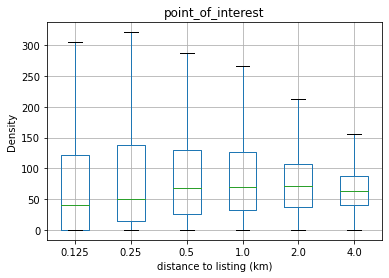

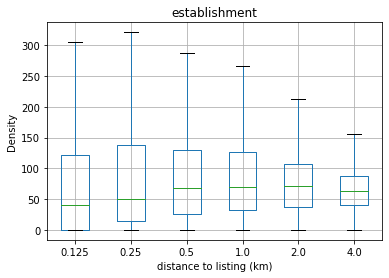

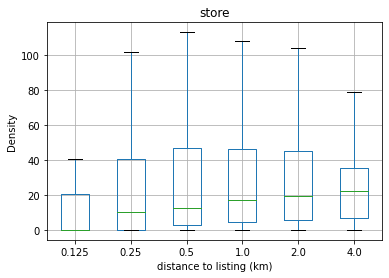

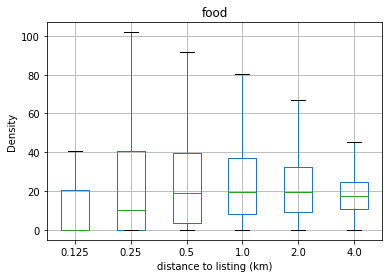

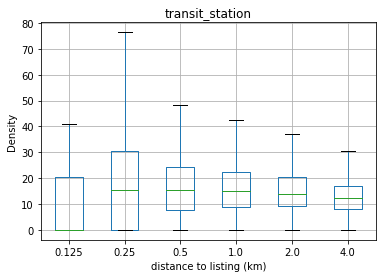

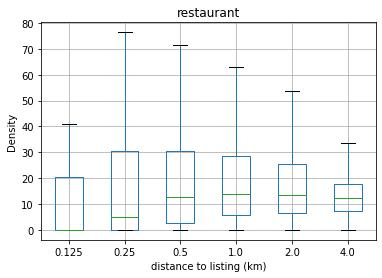

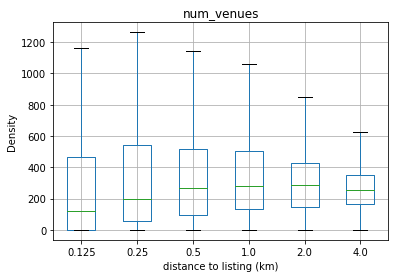

In [102]:

# # @TODO the density at each radius i is not independent
# It's just the average in the circle, which includes also the smaller circle
# Fix it? or acceptable?
r=[0.125,0.25,0.5,1,2,4]

for venue_type in venuesToPlot:
  pd.concat({i: dfs[i][venue_type]/area[i] for i in r},axis=1).boxplot(showfliers=False)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Density')
  plt.show()

#len(dfs2)

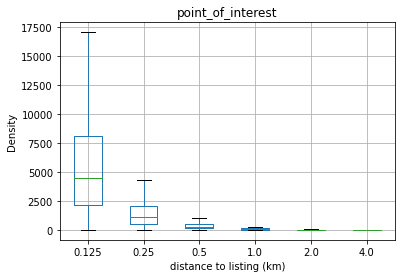

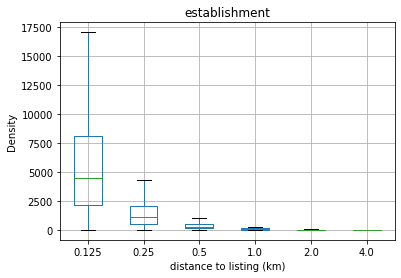

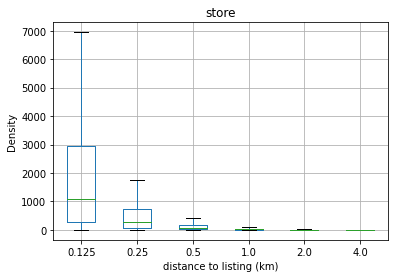

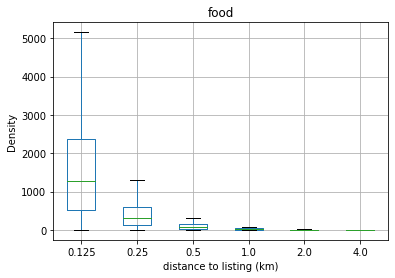

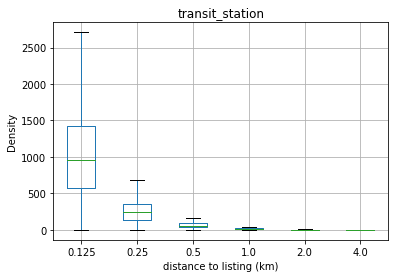

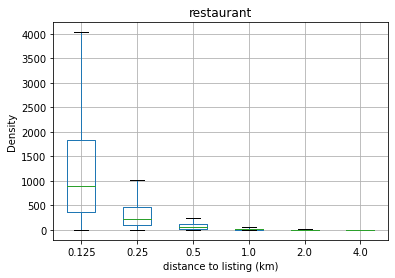

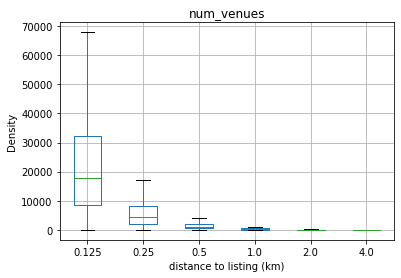

In [103]:

# # @TODO the density at each radius i is not independent
# It's just the average in the circle, which includes also the smaller circle
# Fix it? or acceptable?
r=[0.125,0.25,0.5,1,2,4]

for venue_type in venuesToPlot:
  pd.concat({i: dfs_clean[i][venue_type]/area[i] for i in r},axis=1).boxplot(showfliers=False)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Density')
  plt.show()

#len(dfs2)

In [ ]:
# @TODO the density at each radius i is not independent
# It's just the average in the circle, which includes also the smaller circle
# Fix it? or acceptable?

for venue_type in venuesToPlot:
  pd.concat({i: getNonSingleton(dfs[i])[venue_type]/(3.14*i*i) for i in r},axis=1).boxplot(showfliers=False)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Density')
  plt.show()


In [ ]:
#same as above for multiple listings
for venue_type in venuesToPlot:
  pd.concat({i: getNonSingleton(dfs[i][dfs[i]['multiple_listing']==1])[venue_type]/(3.14*i*i) for i in r},axis=1).boxplot(showfliers=False)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Density')
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


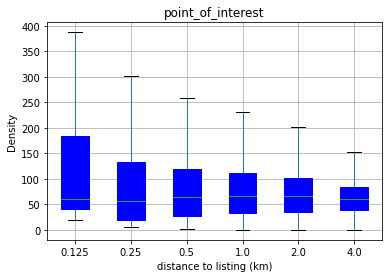

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


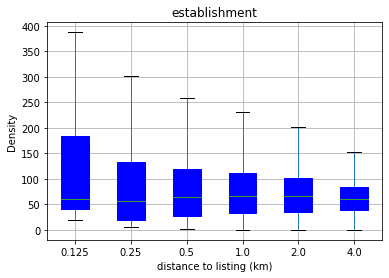

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


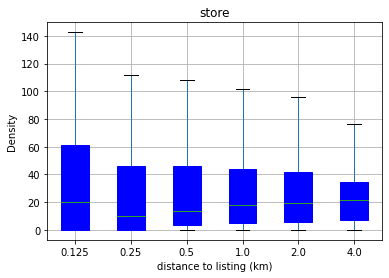

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


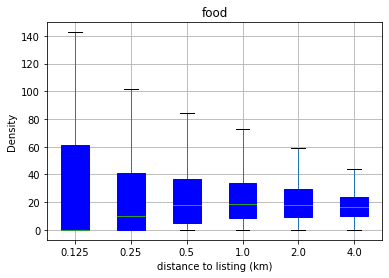

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


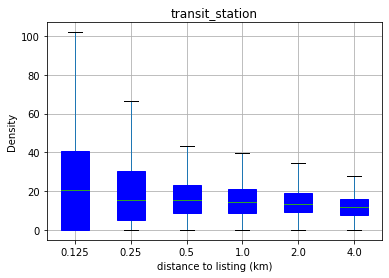

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


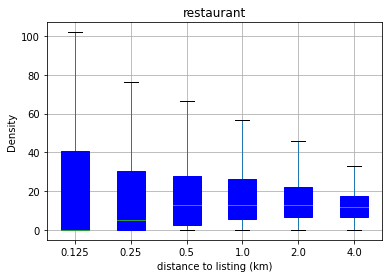

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


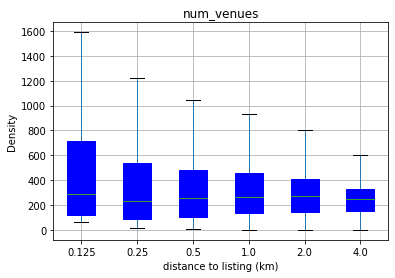

In [ ]:
#same for single listings
for venue_type in venuesToPlot:
  scheme = dict(boxes="Blue")
  pd.concat({i: getNonSingleton(dfs[i][dfs[i]['multiple_listing']==0])[venue_type]/(3.14*i*i) for i in r},axis=1).boxplot(showfliers=False,color=scheme,patch_artist=True)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Density')
  plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


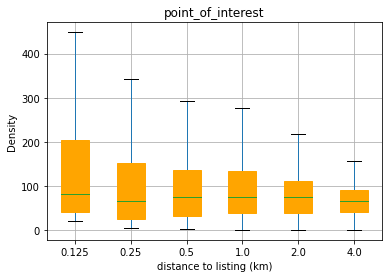

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


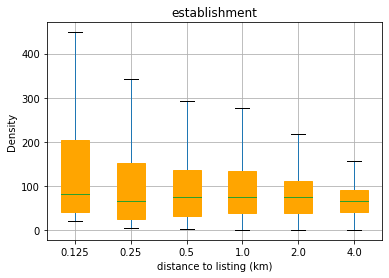

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


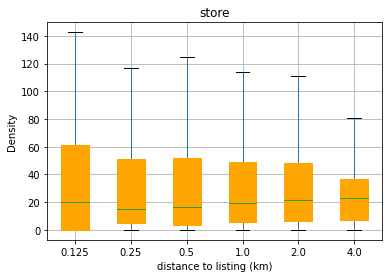

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


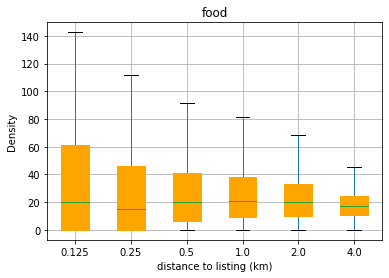

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


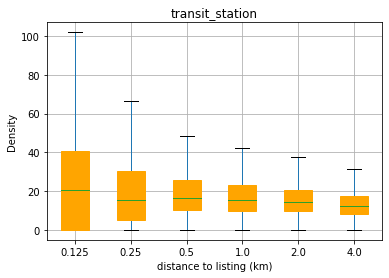

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


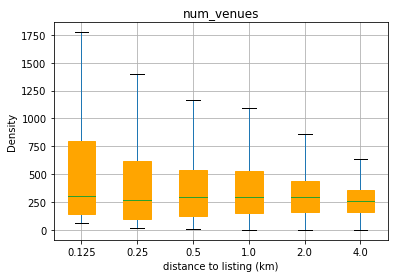

In [ ]:
#same for 2-5_listings
scheme = dict(boxes="Orange")
for venue_type in venuesToPlot:
  pd.concat({i: getNonSingleton(dfs[i][dfs[i]['2-5_listings']==1])[venue_type]/(3.14*i*i) for i in r},axis=1).boxplot(showfliers=False,color=scheme,patch_artist=True)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Density')
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


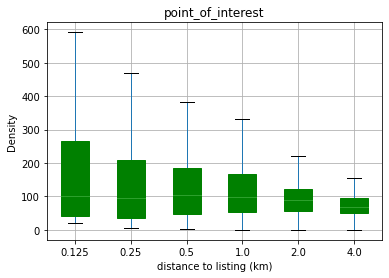

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


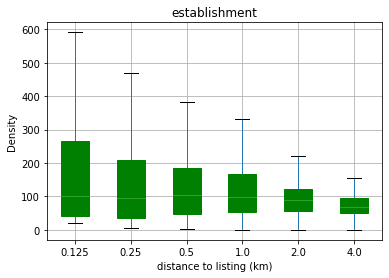

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


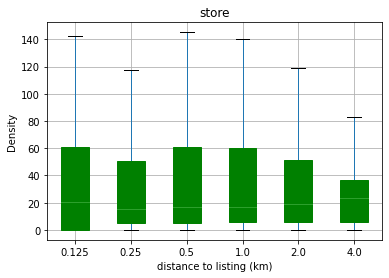

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


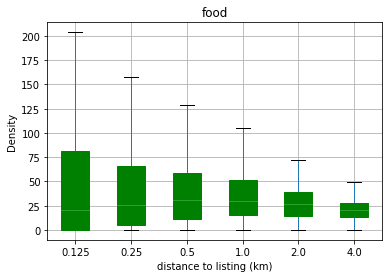

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


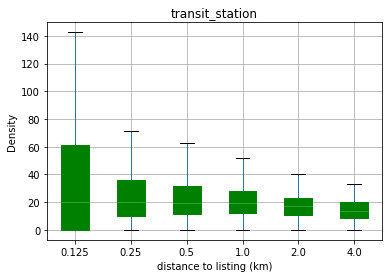

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


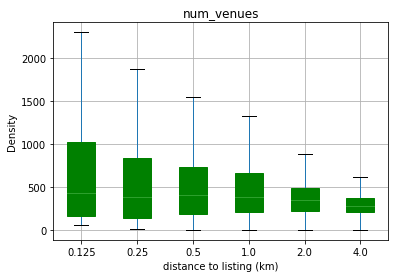

In [ ]:
#same for 6-10_listings
scheme = dict(boxes="Green")
for venue_type in venuesToPlot:
  pd.concat({i: getNonSingleton(dfs[i][dfs[i]['6-10_listings']==1])[venue_type]/(3.14*i*i) for i in r},axis=1).boxplot(showfliers=False,color=scheme,patch_artist=True)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Density')
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


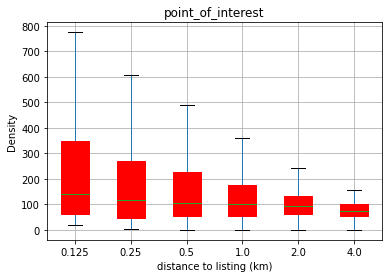

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


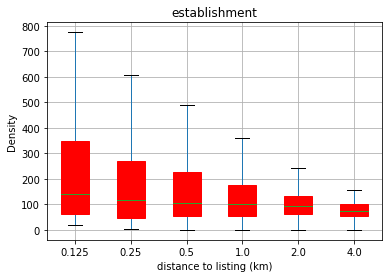

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


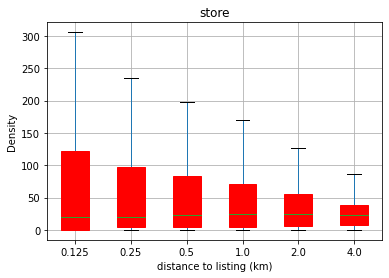

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


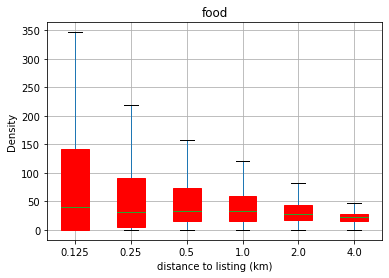

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


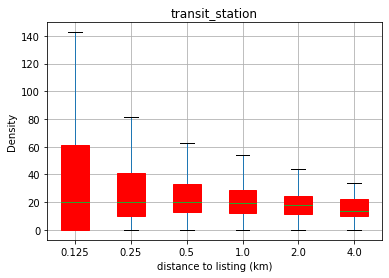

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


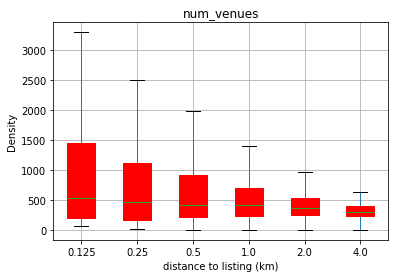

In [ ]:
#same for 11+_listings
scheme = dict(boxes="Red")
for venue_type in venuesToPlot:
  pd.concat({i: getNonSingleton(dfs[i][dfs[i]['11+_listings']==1])[venue_type]/(3.14*i*i) for i in r},axis=1).boxplot(showfliers=False,color=scheme,patch_artist=True)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Density')
  plt.show()

## Plotting the counts

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


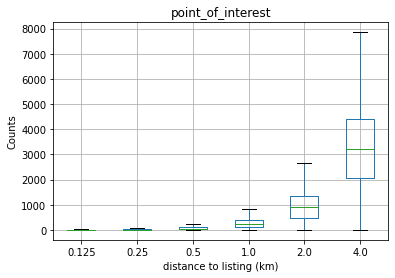

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


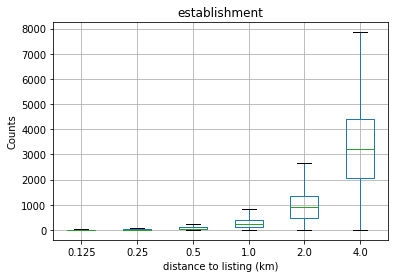

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


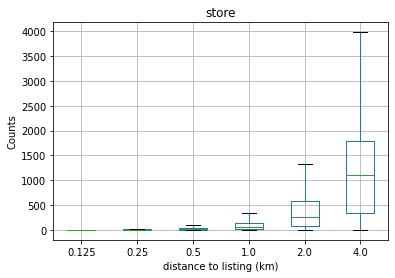

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


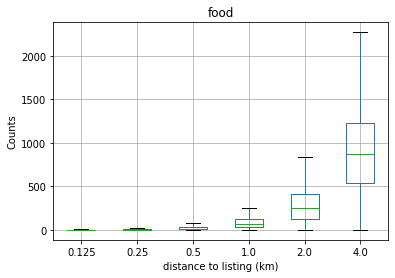

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


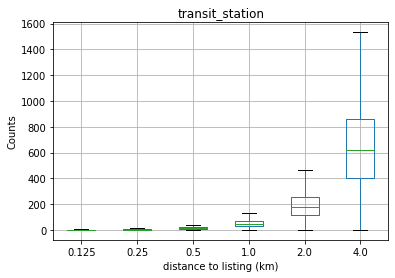

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


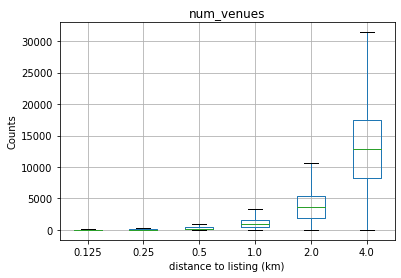

In [ ]:
for venue_type in venuesToPlot:
  pd.concat({i: getNonSingleton(dfs[i])[venue_type] for i in r},axis=1).boxplot(showfliers=False)
  plt.title(venue_type)
  plt.xlabel('distance to listing (km)')
  plt.ylabel('Counts')
  plt.show()

# Correlation Analysis

In [ ]:
!pip install dataprep -q
from dataprep.eda import compute_correlation

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


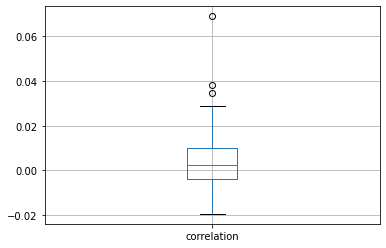

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


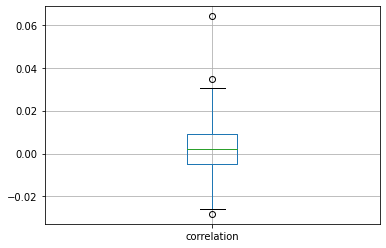

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


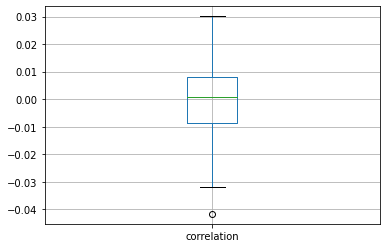

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


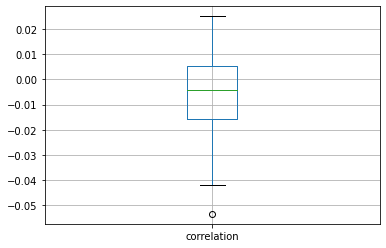

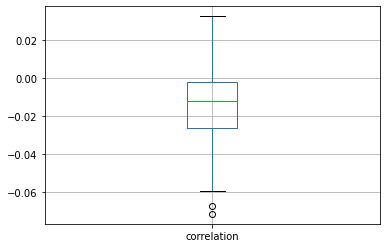

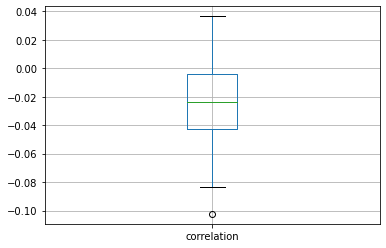

In [ ]:
for i in r:
  cor=compute_correlation(getNonSingleton(dfs[i][['occupancy rate', 'price']+list(df.columns[-101:])]),'occupancy rate' )
  cor['data']['Pearson'].sort_values('correlation').boxplot()
  plt.show()

In [ ]:
cor['data']['Pearson'].sort_values('correlation')

,x,y,correlation
0,occupancy rate,park,-0.102366
1,occupancy rate,atm,-0.083715
2,occupancy rate,gas_station,-0.081601
3,occupancy rate,library,-0.073052
4,occupancy rate,meal_takeaway,-0.071127
...,...,...,...
97,occupancy rate,price,0.015636
98,occupancy rate,casino,0.018200
99,occupancy rate,dentist,0.020561
100,occupancy rate,subpremise,0.031480


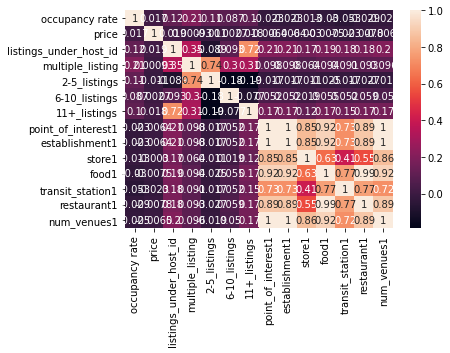

In [ ]:
##New bit Correlation matrix
columns_wanted1 = ['occupancy rate', 'price','listings_under_host_id','multiple_listing','2-5_listings','6-10_listings','11+_listings']
columns_wanted2 = ['point_of_interest','establishment','store','food','transit_station','restaurant','num_venues']
columns_wanted3 = {'point_of_interest':f'point_of_interest{i}','establishment':f'establishment{i}','store':f'store{i}','food':f'food{i}','transit_station':f'transit_station{i}','restaurant':f'restaurant{i}','num_venues':f'num_venues{i}'}

#make new df
# for i in r:
# columns_wanted = 
pre_corr = [dfs[0.25].loc[:,columns_wanted1]]

i=0.5
pre_corr.append(dfs[i].loc[:,columns_wanted2].rename(columns=columns_wanted3))

pre_corr1 = pd.concat(pre_corr, axis=1)
corr = pre_corr1.corr()

sns.heatmap(corr, annot=True)
plt.show()

In [ ]:
r

[0.125, 0.25, 0.5, 1, 2, 4]